In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import levene
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Load the Data

In [3]:
# Load the dataset
train_path = 'C:/Users/Administrator/Desktop/Week 4/Technical Content/Data/train.csv'
train_data = pd.read_csv(train_path, parse_dates=['Date'])

# Display the first few rows
print(train_data.head())


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12340\3043136666.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(train_path, parse_dates=['Date'])


   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  


### Prepare Time Series Data

In [4]:
store_id = 1  # Change as needed
store_data = train_data[train_data['Store'] == store_id]
store_data = store_data.groupby('Date')['Sales'].sum().reset_index()

# Set the date as index
store_data.set_index('Date', inplace=True)

# Display the time series data
print(store_data.head())


            Sales
Date             
2013-01-01      0
2013-01-02   5530
2013-01-03   4327
2013-01-04   4486
2013-01-05   4997


### Check Stationarity

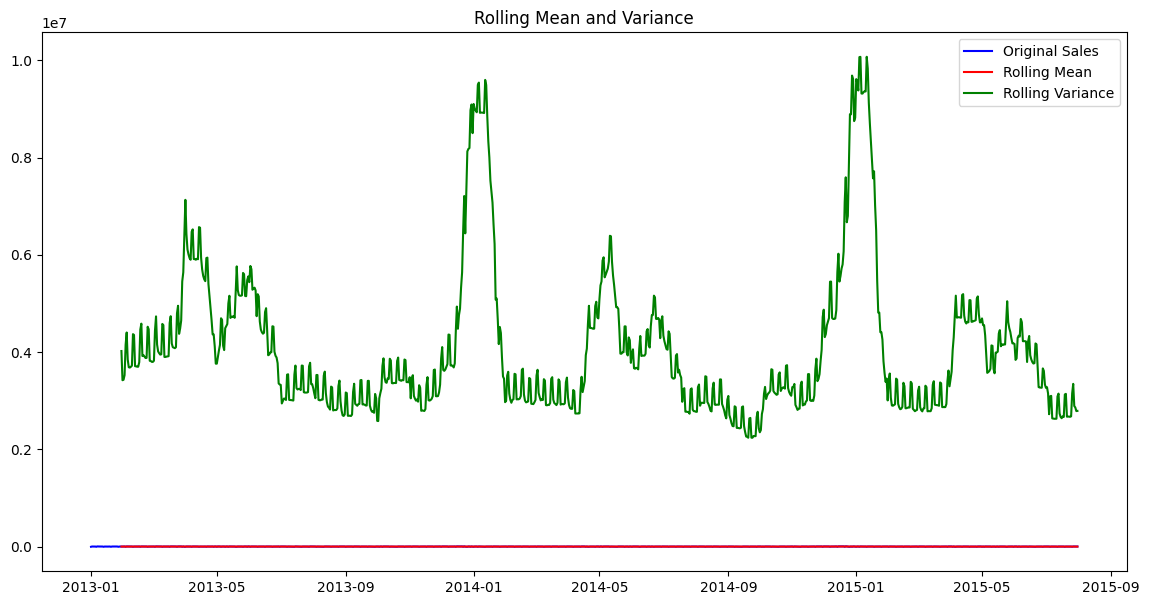

In [5]:
# Calculate rolling mean and variance
rolling_mean = store_data['Sales'].rolling(window=30).mean()
rolling_variance = store_data['Sales'].rolling(window=30).var()

# Plotting to visualize Mean and Variance
plt.figure(figsize=(14, 7))
plt.plot(store_data['Sales'], color='blue', label='Original Sales')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_variance, color='green', label='Rolling Variance')
plt.title('Rolling Mean and Variance')
plt.legend()
plt.show()

In [6]:
#  segment the data into different time periods (e.g., yearly or monthly) and calculate the mean and variance for each segment to see if they remain relatively constant.
# Add year and month columns for grouping
store_data['Year'] = store_data.index.year
store_data['Month'] = store_data.index.month

# Calculate mean and variance for each month or year
grouped_stats = store_data.groupby(['Year', 'Month'])['Sales'].agg(['mean', 'var']).reset_index()

print(grouped_stats)


    Year  Month         mean           var
0   2013      1  4142.935484  3.901355e+06
1   2013      2  4473.964286  4.080161e+06
2   2013      3  4682.870968  6.209515e+06
3   2013      4  3933.633333  3.764562e+06
4   2013      5  3813.709677  5.874034e+06
5   2013      6  3780.366667  3.337433e+06
6   2013      7  4130.064516  3.304954e+06
7   2013      8  3816.774194  2.677518e+06
8   2013      9  3628.900000  3.052475e+06
9   2013     10  3698.096774  3.276722e+06
10  2013     11  4253.200000  3.332610e+06
11  2013     12  4682.838710  8.974973e+06
12  2014      1  3832.709677  3.379605e+06
13  2014      2  3944.071429  3.145748e+06
14  2014      3  3757.000000  3.444643e+06
15  2014      4  3843.066667  4.695312e+06
16  2014      5  3797.258065  4.152019e+06
17  2014      6  3596.833333  4.738446e+06
18  2014      7  3954.967742  2.741159e+06
19  2014      8  3580.774194  2.993821e+06
20  2014      9  3546.600000  2.434133e+06
21  2014     10  3706.354839  3.036173e+06
22  2014   

In [7]:
#Statistical Test for Stationarity
# Extract sales data for each year
years = store_data['Year'].unique()
sales_per_year = [store_data[store_data['Year'] == year]['Sales'] for year in years]

# Perform Levene's test
stat, p_value = levene(*sales_per_year)
print('Levene’s test statistic:', stat)
print('p-value:', p_value)

if p_value < 0.05:
    print("Variances are significantly different, suggesting non-stationarity.")
else:
    print("Variances are similar, suggesting potential stationarity.")


Levene’s test statistic: 0.8772138166280977
p-value: 0.416280759884342
Variances are similar, suggesting potential stationarity.


### Check Autocorrelation and Partial Autocorrelation

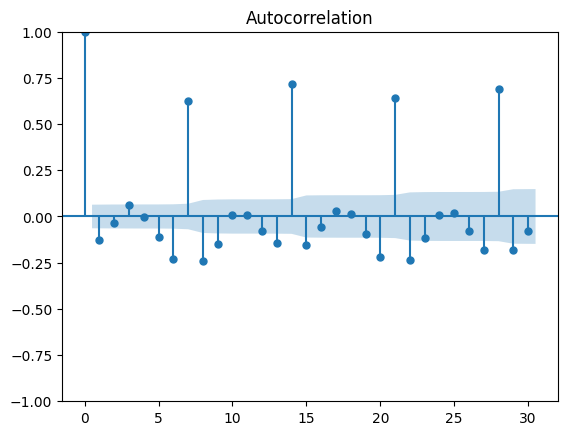

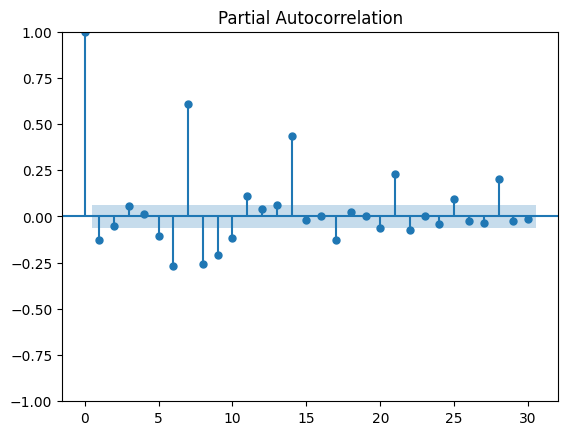

In [8]:
plot_acf(store_data['Sales'])
plot_pacf(store_data['Sales'])
plt.show()


### Create Supervised Learning Data

In [9]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 30  # Number of previous days to consider
data_values = store_data.values
X, y = create_dataset(data_values, time_step)

# Reshape for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)
X.shape


(911, 30, 1)

### Scale the Data

In [10]:
# Scale the data to the range (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data_values)

# Split the dataset into training and testing
train_size = int(len(data_scaled) * 0.8)
train, test = data_scaled[0:train_size], data_scaled[train_size:len(data_scaled)]

# Create datasets
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)


### Build the LSTM Model

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


### Train the Model

In [12]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
23/23 [==============================] - 20s 39ms/step - loss: 0.1895
Epoch 2/50
23/23 [==============================] - 1s 38ms/step - loss: 0.1849
Epoch 3/50
23/23 [==============================] - 1s 39ms/step - loss: 0.1842
Epoch 4/50
23/23 [==============================] - 1s 40ms/step - loss: 0.1838
Epoch 5/50
23/23 [==============================] - 1s 40ms/step - loss: 0.1827
Epoch 6/50
23/23 [==============================] - 1s 40ms/step - loss: 0.1825
Epoch 7/50
23/23 [==============================] - 1s 41ms/step - loss: 0.1841
Epoch 8/50
23/23 [==============================] - 1s 37ms/step - loss: 0.1834
Epoch 9/50
23/23 [==============================] - 1s 39ms/step - loss: 0.1808
Epoch 10/50
23/23 [==============================] - 1s 40ms/step - loss: 0.1820
Epoch 11/50
23/23 [==============================] - 1s 39ms/step - loss: 0.1816
Epoch 12/50
23/23 [==============================] - 1s 41ms/step - loss: 0.1805
Epoch 13/50
23/23 [=================

### Make Predictions

In [13]:
# Assuming store_data['Sales']
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(store_data[['Sales']])  


MinMaxScaler(feature_range=(-1, 1))

In [14]:
# After predicting with the model
y_pred = model.predict(X_test)

# Reshape y_pred to match the original feature shape (e.g., if it was fitted with one feature)
y_pred = y_pred.reshape(-1, 1)  # Ensure it's a 2D array with shape (n_samples, 1)

# Inverse transform the predictions
y_pred_inv = scaler.inverse_transform(y_pred)

print("Shape of scaler.min_:", scaler.min_.shape)
print("Shape of scaler.scale_:", scaler.scale_.shape)
print("Shape of y_pred after reshaping:", y_pred.shape)



5/5 [==============================] - 3s 16ms/step
Shape of scaler.min_: (1,)
Shape of scaler.scale_: (1,)
Shape of y_pred after reshaping: (158, 1)


### Visualize the Result

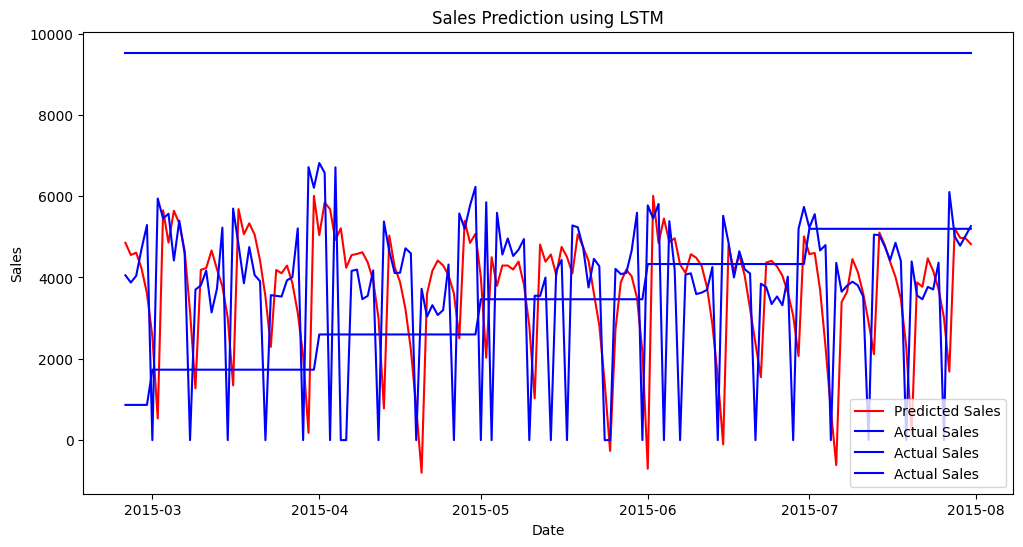

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(store_data.index[train_size + time_step + 1:], y_pred_inv, color='red', label='Predicted Sales')
plt.plot(store_data.index[train_size + time_step + 1:], scaler.inverse_transform(test[time_step + 1:]), color='blue', label='Actual Sales')
plt.title('Sales Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
